In [2]:
import bt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True


In [54]:
# download some data & calc SMAs
data = bt.get('iwy', start='2019-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()
# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

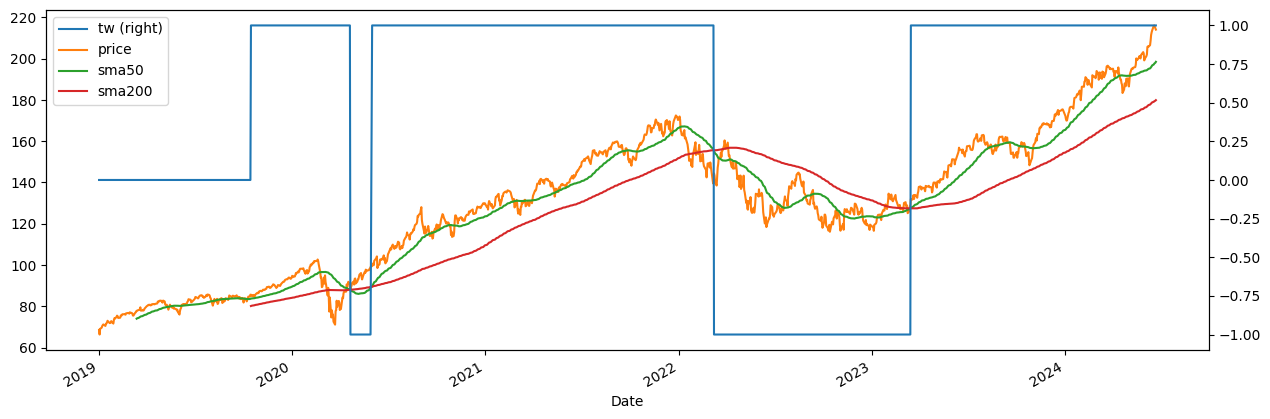

In [55]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

<Axes: title={'center': 'Equity Progression'}>

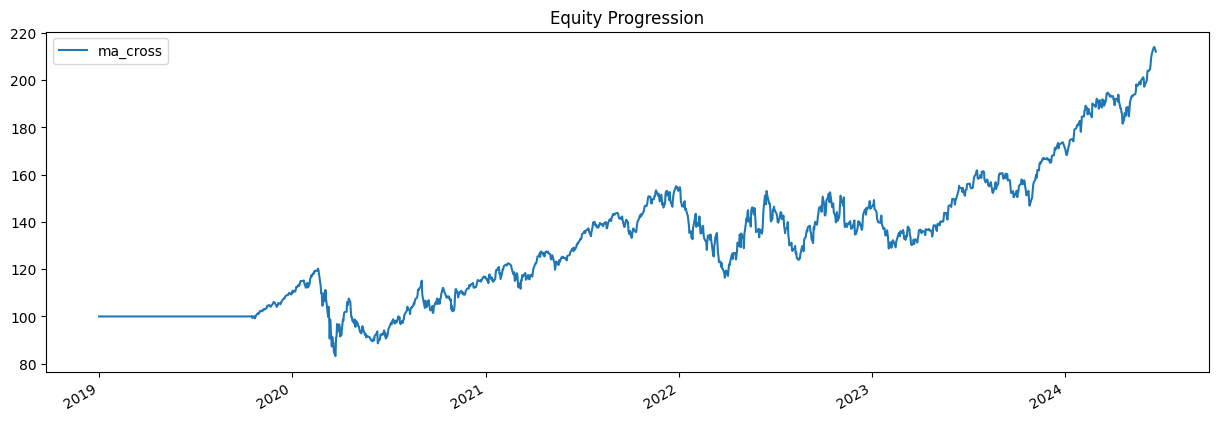

In [56]:
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)
res.plot()



<Axes: title={'center': 'Equity Progression'}>

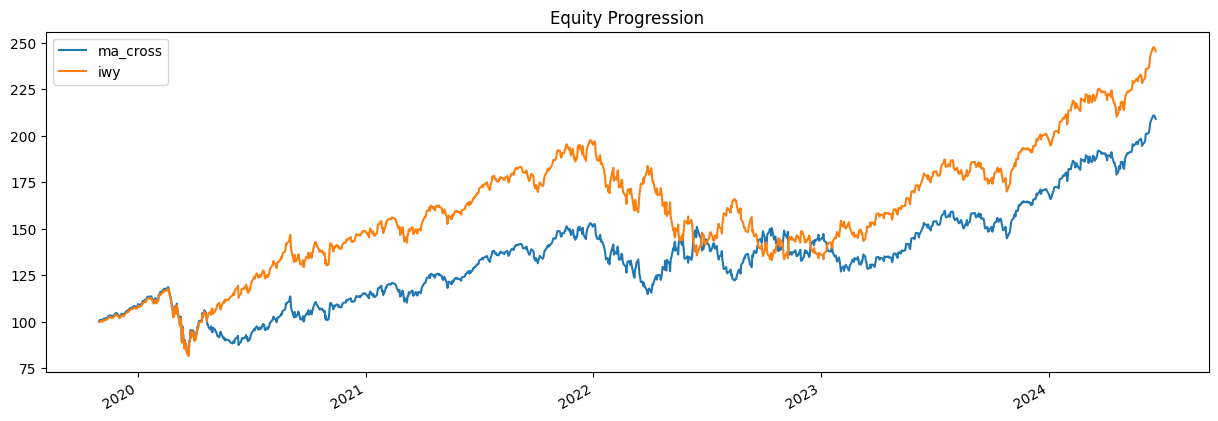

In [47]:
def long_only_ew(tickers, start='2019-11-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)
benchmark = long_only_ew('iwy', name='iwy')
# run all the backtests!
res2 = bt.run(t,benchmark)
res2.plot()

In [42]:
def ma_cross(ticker, start='2010-01-01',
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = 0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

# ok now let's create a few backtests and gather the results.
# # these will later become our "synthetic securities"
# t1 = ma_cross('aapl', name='aapl_ma_cross')
# t2 = ma_cross('msft', name='msft_ma_cross')
# tickers = 'rsp,iwy,moat,pff,vnq'

t1 = ma_cross('rsp', name='rsp_cross')
t2 = ma_cross('iwy', name='iwy_cross')
t3 = ma_cross('moat', name='moat_cross')
t4 = ma_cross('pff', name='pff_cross')
t5 = ma_cross('vnq', name='vnq_cross')
# let's run these strategies now
res = bt.run(t1, t2,t3,t4,t5)

<Axes: title={'center': 'Equity Progression'}>

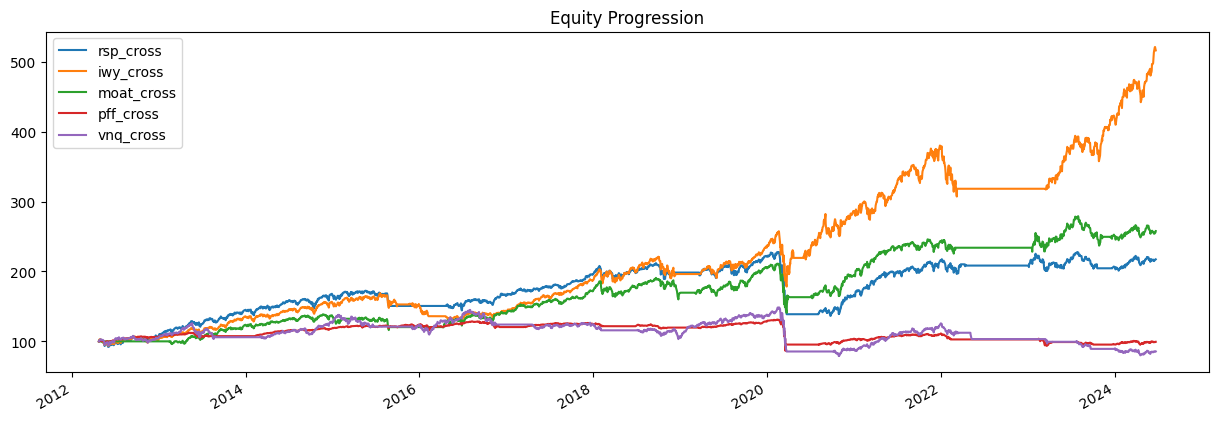

In [37]:
res.plot()

In [43]:
# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['rsp_cross'].prices, res['iwy_cross'].prices,res['moat_cross'].prices,res['pff_cross'].prices,res['vnq_cross'].prices)

# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighEqually(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res_new = bt.run(t)

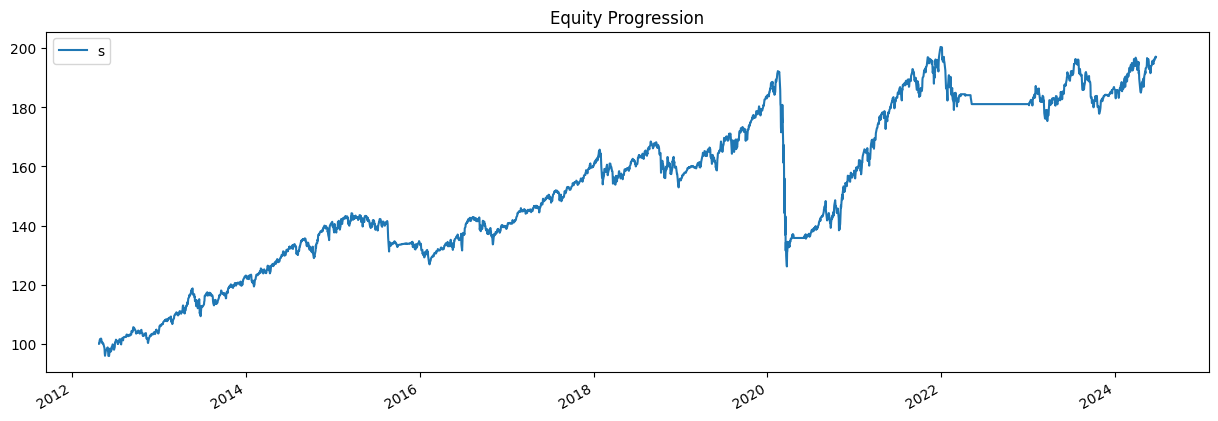

In [45]:
res_new.plot();

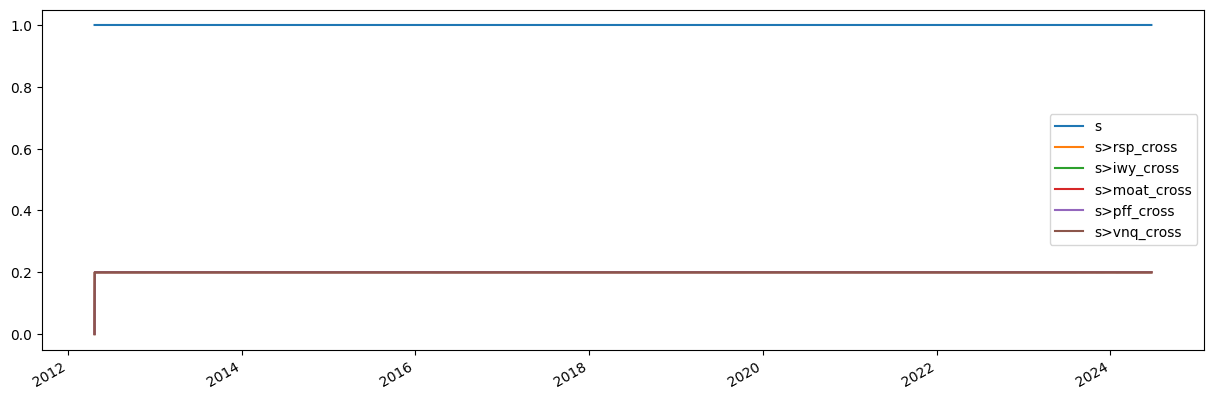

In [46]:
res_new.plot_weights();